### In this notebook, we'll generate mean and probabilistic wind power forecasts on the GEFCom2014 data set

You can have a look at the [previous notebook](https://github.com/DWvanderMeer/ConformalPrediction/blob/main/analyze_GEFCom_data.ipynb) in which we analyze the data in dept; here we simply load the data and perform the necessary quality checks for our regression.

As a base regressor, we use a random forest. Note that MAPIE allows any regressor as long as it has fit and predict methods!

In [7]:
import os
import pandas as pd
import glob
from natsort import os_sorted
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import randint

from operational_analysis.toolkits import filters
from operational_analysis.toolkits import power_curve

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

from mapie.metrics import (regression_coverage_score,
                           regression_mean_width_score)
from mapie.regression import MapieRegressor

PATH = "/Users/dennis.van_der_meer/Documents/Projects/ConformalPrediction/data/GefCom2014/wind/"

Load the data and filter anomalies. This can be done in a nicer way but that's not the point of this notebook.

In [2]:
# List and sort the csv files of the exogenous data
files = os_sorted(glob.glob(os.path.join(PATH, "*ExpVars*.csv")))
# Read the exogenous data of Task 15 for all 10 zones for the final month
lst = []
for file in files:
    df = pd.read_csv(file, index_col = ["TIMESTAMP", "ZONEID"], parse_dates = True)
    df['WS10'] = np.sqrt(df['U10']**2 + df['V10']**2)
    df['WS100'] = np.sqrt(df['U100']**2 + df['V100']**2)
    df['WD10'] = np.mod(180 + 180/np.pi * np.arctan2(df['V10'], df['U10']), 360)
    df['WD100'] = np.mod(180 + 180/np.pi * np.arctan2(df['V100'], df['U100']), 360)
    df = df.drop(['U10', 'V10', 'U100', 'V100'], axis=1)
    lst.append(df)
df = pd.concat(lst)
# Read the target data of Task 15 for the final month
file = os.path.join(PATH, "solution15_W.csv")
solutions = pd.read_csv(file, index_col = ["TIMESTAMP", "ZONEID"], parse_dates = True)
# Join the exogenous variables and target data of Task 15 for the final month
tmp = df.merge(solutions, how = 'left', left_index = True, right_index = True)
# List and sort the csv files of the exogenous and target data
files = os_sorted(glob.glob(os.path.join(PATH, "Task15_*.csv")))
# Read the exogenous data of Task 15 for all 10 zones for the final month
lst = []
for file in files:
    df = pd.read_csv(file, index_col = ["TIMESTAMP", "ZONEID"], parse_dates = True)
    df['WS10'] = np.sqrt(df['U10']**2 + df['V10']**2)
    df['WS100'] = np.sqrt(df['U100']**2 + df['V100']**2)
    df['WD10'] = np.mod(180 + 180/np.pi * np.arctan2(df['V10'], df['U10']), 360)
    df['WD100'] = np.mod(180 + 180/np.pi * np.arctan2(df['V100'], df['U100']), 360)
    df = df.drop(['U10', 'V10', 'U100', 'V100'], axis=1)
    lst.append(df)
df = pd.concat(lst)
dat = pd.concat([df, tmp])
dat = dat.groupby('ZONEID').apply(lambda group: group.interpolate(method = 'linear', limit_direction = 'both'))
# From here on out, we consider the first zone (out of 10 zones)
windspeed = dat.xs(1, level = 1, drop_level = True)["WS100"]
power = dat.xs(1, level = 1, drop_level = True)["TARGETVAR"]
# Window range filter
out_of_window = filters.window_range_flag(windspeed, 5., 40, power, 0.01, 1.05)
windspeed_filt1 = windspeed[~out_of_window]
power_filt1 = power[~out_of_window]
# Bin filter
bin_outliers = filters.bin_filter(power_filt1, windspeed_filt1, 0.025, 3., 'median', 0.01, 0.9, 'scalar', 'all')
windspeed_filt2 = windspeed_filt1[~bin_outliers]
power_filt2 = power_filt1[~bin_outliers]

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In contrast to the previous notebook, we keep all exogenous variables rather than only the wind speed at 100 m.

In [16]:
filt1 = dat.xs(1, level = 1, drop_level = True)[~out_of_window]
filt2 = filt1[~bin_outliers]

In [24]:
# Define train, calibration and test set
train_X = filt2.loc['2012-01-01':'2012-12-31', filt2.columns != 'TARGETVAR']
train_y = filt2.loc['2012-01-01':'2012-12-31', filt2.columns == 'TARGETVAR']

cal_X = filt2.loc['2013-01-01':'2013-06-30', filt2.columns != 'TARGETVAR']
cal_y = filt2.loc['2013-01-01':'2013-06-30', filt2.columns == 'TARGETVAR']

test_X = filt2.loc['2013-07-01':'2013-12-31', filt2.columns != 'TARGETVAR']
test_y = filt2.loc['2013-07-01':'2013-12-31', filt2.columns == 'TARGETVAR']

The next step is to train and validate a random forest on the training data using a built-in cross-validation parameter search specifically designed for time series.

In [34]:
# CV parameter search
n_iter = 10
n_splits = 5
tscv = TimeSeriesSplit(n_splits = n_splits)
random_state = 59
rf_model = RandomForestRegressor(random_state = random_state)
rf_params = {"max_depth": randint(2, 8), "n_estimators": randint(10, 1000)}
cv_obj = RandomizedSearchCV(
    rf_model,
    param_distributions = rf_params,
    n_iter = n_iter,
    cv = tscv,
    scoring = "neg_root_mean_squared_error",
    random_state = random_state,
    verbose = 0,
    n_jobs = -1,
)
cv_obj.fit(train_X, np.ravel(train_y))
best_est = cv_obj.best_estimator_

In [35]:
print(best_est)

RandomForestRegressor(max_depth=7, n_estimators=673, random_state=59)


### Now that the base model has been estimated, we can use the MAPIE regressor to conformalize it.

Specifically, we're interested in the prediction interval that covers 95% of the true values on average, so we set alpha to 0.05.

In [39]:
mapie_reg = MapieRegressor(estimator = best_est, cv = "prefit")
mapie_reg.fit(cal_X, np.ravel(cal_y))
y_pred, y_cis = mapie_reg.predict(test_X, alpha = 0.05)
coverage = regression_coverage_score(test_y, y_cis[:, 0, 0], y_cis[:, 1, 0])
width = regression_mean_width_score(y_cis[:, 0, 0], y_cis[:, 1, 0])

# Print results
print(
    "Coverage and prediction interval width mean for prefit: "
    f"{coverage:.3f}, {width:.3f}"
)

Coverage and prediction interval width mean for prefit: 0.962, 0.665


The average coverage is very close to what we expect from our 95% prediction interval! Let's plot the result on the test set.

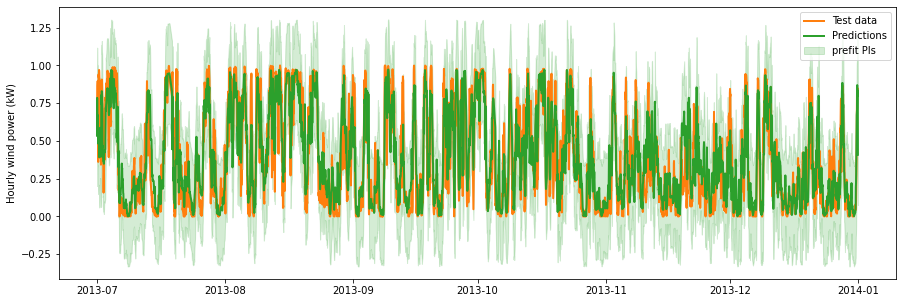

In [37]:
# Plot estimated prediction intervals on test set
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)
ax.set_ylabel("Hourly wind power (kW)")
ax.plot(test_y.TARGETVAR, lw=2, label="Test data", c="C1")
ax.plot(test_y.index, y_pred, lw=2, c="C2", label="Predictions")
ax.fill_between(
    test_y.index,
    y_cis[:, 0, 0],
    y_cis[:, 1, 0],
    color = "C2",
    alpha = 0.2,
    label = "prefit PIs",
)
ax.legend()
plt.show()

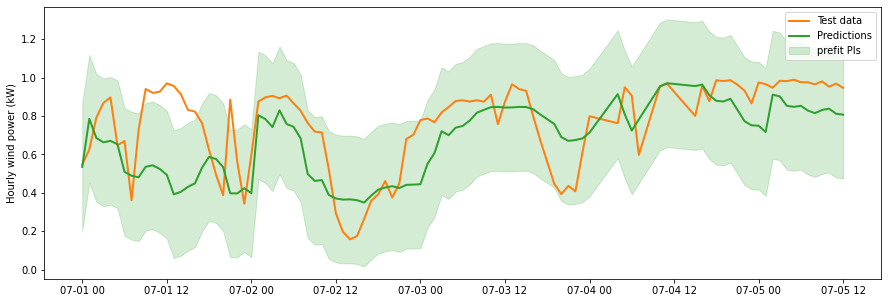

In [47]:
# Plot estimated prediction intervals on test set
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)
ax.set_ylabel("Hourly wind power (kW)")
ax.plot(test_y.iloc[0:100, 0], lw=2, label="Test data", c="C1")
ax.plot(test_y[0:100].index, y_pred[0:100], lw=2, c="C2", label="Predictions")
ax.fill_between(
    test_y[0:100].index,
    y_cis[0:100, 0, 0],
    y_cis[0:100, 1, 0],
    color = "C2",
    alpha = 0.2,
    label = "prefit PIs",
)
ax.legend()
plt.show()

In these figure we see that there's a problem with this method for this specific use case. Namely, wind power production is a bounded process ([0, 1]), yet the prediction intervals extend beyond this range. The next step is to conformalize quantile regression and experiment with quantile regression forests!